# 将RGBA图片修改为RGB

In [33]:
import os
import cv2
'''png格式常常是32位的RGBA格式，A代表透明度，
   光是更改图片后缀，不能改变图片的位数，
   需要在openCV中进行色彩空间的转换，
   将png格式的32位RGBA转为jpg格式的24位RGB'''

def convert2jpg(filename):                                      # 将彩色图转灰度图的函数
    img = cv2.imread(file_path+'/'+filename, 1)                 # 1是以彩色图方式去读
    jpg_img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    cv2.imwrite(out_path + '/' + filename, jpg_img)             # 保存在新文件夹下，且图名中加GRAY

file_path = "./edit"                         # 输入文件夹
#os.mkdir("./edit")                           # 建立新的目录
out_path ="./attack"                           # 设置为新目录为输出文件夹

for filename in os.listdir(file_path):                          # 遍历输入路径，得到图片名
    print(filename)
    convert2jpg(filename)


test23.jpg
test24.jpg
test25.jpg
test26.jpg
test27.jpg
test29.jpg
test30.jpg
test31.jpg
test32.jpg
test33.jpg
test38.png
test39.png
test40.png
test41.png
test42.png


# 初始化数据集和网络

In [12]:
import copy
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd #用于更轻松的csv解析
from PIL import Image
import random
from scipy.optimize import differential_evolution
from skimage import io
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms


print("ALIVE")

characters = ["marin", "miku", "kaguya"]

#数据集
class MyData(Dataset):
    def __init__(self, root_dir, csvfile, transform=transforms.ToTensor()):
        self.root_dir = root_dir#图像所在目录
        self.csv = pd.read_csv(csvfile)#标记所在目录
        print("DATA SET")
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
           
        #图片路径
        img_path = os.path.join(self.root_dir, self.csv.iloc[idx, 0])#单个图像路径    
        image_transform = transforms.Compose([
        # 将输入图片resize成统一尺寸
        transforms.Resize([128, 128]),
        # 将PIL Image或numpy.ndarray转换为tensor，并除255归一化到[0,1]之间
        transforms.ToTensor(),
        # 标准化处理-->转换为标准正太分布，使模型更容易收敛
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

        image = Image.open(img_path)#打开图像
        image = image_transform(image)
        label = self.csv.iloc[idx, 1]#打开图像对应标签
        label = np.array(label)#标签矩阵化
        return image, label, #返回图像和标签
    
    def __len__(self):
        return len(self.csv)#返回图片个数
    
#没有标准化处理的数据集，用作攻击
class MyData2(Dataset):
    def __init__(self, root_dir, csvfile, transform=transforms.ToTensor()):
        self.root_dir = root_dir#图像所在目录
        self.csv = pd.read_csv(csvfile)#标记所在目录
        print("DATA SET")
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
           
        #图片路径
        img_path = os.path.join(self.root_dir, self.csv.iloc[idx, 0])#单个图像路径
        
        image_transform = transforms.Compose([
        # 将输入图片resize成统一尺寸
        transforms.Resize([128, 128]),
        # 将PIL Image或numpy.ndarray转换为tensor，并除255归一化到[0,1]之间
        transforms.ToTensor(),
        # 标准化处理-->转换为标准正太分布，使模型更容易收敛
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])

        image = Image.open(img_path)#打开图像
        image = image_transform(image)
        label = self.csv.iloc[idx, 1]#打开图像对应标签
        label = np.array(label)#标签矩阵化
        return image, label, #返回图像和标签
    
    def __len__(self):
        return len(self.csv)#返回图片个数
    
    
#数据集对象实例化
mydata = MyData(root_dir = "./after3", csvfile = "./after3/after3.csv")#训练数据
trainloader = torch.utils.data.DataLoader(mydata, batch_size = 100, shuffle = True)
testdata = MyData(root_dir = "./try", csvfile = "./try/try.csv")#测试数据
testloader = torch.utils.data.DataLoader(testdata, batch_size = 1, shuffle = True)
attackdata = MyData2(root_dir = "./attack", csvfile = "./attack/attack.csv")#攻击数据
attackloader = torch.utils.data.DataLoader(attackdata, shuffle = False)
afterdata = MyData2(root_dir = "./train", csvfile = "./train/train.csv")#扰动后数据
afterloader = torch.utils.data.DataLoader(afterdata, batch_size = 1, shuffle = False)

#神经网络
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)#第一卷积层
        self.conv2 = nn.Conv2d(64, 1, 5)#第二卷积层
        self.fc1 = nn.Linear(1600, 256)#第一全连接层
        self.fc2 = nn.Linear(256, 3)
        self.pool = nn.MaxPool2d(3, 3)#池化层
        
    def forward(self, x):
        x = F.relu(self.conv1(x))#第一层卷积后relu
        x = self.pool(F.relu(self.conv2(x)))#第二层卷积后relu且池化
        x = x.view(x.shape[0], -1)#将图片降维
        x = F.relu(self.fc1(x))#带入第一全连接层
        x = self.fc2(x)
        return x
    
#神经网络对象实例化
print("MODEL SET")
net = MyNet()

#模型保存路径
PATH = ".\myModel-2.pth"


ALIVE
DATA SET
DATA SET
DATA SET
DATA SET
MODEL SET


# 训练神经网络

In [3]:
#定义损失和优化
MyLoss = nn.CrossEntropyLoss()#交叉熵
MyOptim = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)#更新权重使用SGD更新规则


print("Start training!!!")

for epoch in range(15):#训练十次防止过拟合
    runningLoss = 0
    print("\n-->EPOCH:", epoch)
    for i, data in enumerate(trainloader, 0):#遍历训练数据
        
        inputs, labels = data#带入训练数据
        
        MyOptim.zero_grad()#清零梯度
        
        #print(inputs.shape)
        outputs = net(inputs.to(torch.float32))#带入神经网络
        
        
        loss = MyLoss(outputs, labels)#计算损失
        
        
        loss.backward()#反向传播
        
       
        MyOptim.step()#更改权重
        
        runningLoss += loss.item()
        
    print("Loss", runningLoss)
    runningLoss = 0
        
  
print("\nProcess done...")


#保存神经网络模型

torch.save(net.state_dict(), PATH)
print("Successfully Saved...\n")

Start training!!!

-->EPOCH: 0
Loss 64.9605702161789

-->EPOCH: 1
Loss 22.586461178958416

-->EPOCH: 2
Loss 6.7054756712168455

-->EPOCH: 3
Loss 4.084041508845985

-->EPOCH: 4
Loss 2.286012116353959

-->EPOCH: 5
Loss 1.2317344893235713

-->EPOCH: 6
Loss 0.8550743779633194

-->EPOCH: 7
Loss 0.6080471783643588

-->EPOCH: 8
Loss 0.6259400200797245

-->EPOCH: 9
Loss 0.3662434268044308

-->EPOCH: 10
Loss 0.28251621779054403

-->EPOCH: 11
Loss 0.22824398119701073

-->EPOCH: 12
Loss 0.1935069459141232

-->EPOCH: 13
Loss 0.3528742193011567

-->EPOCH: 14
Loss 0.22475842700805515

Process done...
Successfully Saved...



# 测试数据

In [14]:
net.load_state_dict(torch.load(PATH))
net.eval()

tc = [0,0,0]#统计各个人物出现的次数
c = [0,0,0]#统计各个人物识别正确的次数
#开始测试数据
total_correct = total = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        images, labels = data
        outputs = net(images.to(torch.float32))
        name, predicts = torch.max(outputs.data, 1)
        if predicts == labels:
            total_correct += 1
            tc[labels] += 1
        total += 1
        c[labels] += 1
print("当前使用的是testloader数据集")
print("共计：", total, "正确：", total_correct,"准确率：", total_correct / total)
print("marin出现次数:", c[0], "正确：", tc[0],"准确率：", tc[0] / c[0])
print("miku出现次数：", c[1], "正确：", tc[1],"准确率：", tc[1] / c[1])
print("kaguya出现次数:", c[2], "正确：", tc[2],"准确率：", tc[2] / c[2])

当前使用的是testloader数据集
共计： 120 正确： 91 准确率： 0.7583333333333333
marin出现次数: 45 正确： 44 准确率： 0.9777777777777777
miku出现次数： 35 正确： 19 准确率： 0.5428571428571428
kaguya出现次数: 40 正确： 28 准确率： 0.7


# FGSM攻击网络模型

C:\Users\jinle\AppData\Local\Temp\ipykernel_17440\2448173834.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ori = torch.tensor(ori)#转为tensor
C:\Users\jinle\AppData\Local\Temp\ipykernel_17440\2448173834.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


Epsilon: 0	Test Accuracy = 20 / 30 = 0.6666666666666666

Epsilon: 0.01	Test Accuracy = 16 / 30 = 0.5333333333333333

Epsilon: 0.015	Test Accuracy = 14 / 30 = 0.4666666666666667

Epsilon: 0.02	Test Accuracy = 11 / 30 = 0.36666666666666664

Epsilon: 0.025	Test Accuracy = 11 / 30 = 0.36666666666666664

Epsilon: 0.03	Test Accuracy = 11 / 30 = 0.36666666666666664

Epsilon: 0.035	Test Accuracy = 11 / 30 = 0.36666666666666664

Epsilon: 0.04	Test Accuracy = 11 / 30 = 0.36666666666666664



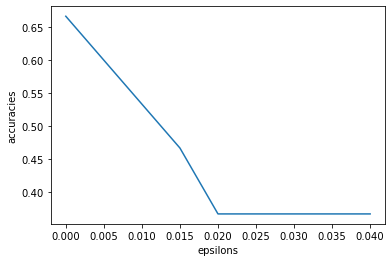

In [15]:
net.load_state_dict(torch.load(PATH))
net.eval()


#扰动
epsilons = [0, .01, .015, .02, .025, .03, .035, .04]
accuracies = []


def fgsm_attack(image, epsilon, data_grad):
    # 取图片张量每个元素的梯度
    sign_data_grad = data_grad.sign()
    # 在每个像素上添加扰动，幅度取决于epsilon
    perturbed_image = image + epsilon*sign_data_grad
    # 将图片张量的每个元素的取值控制在0和1之间
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回扰动图片
    return perturbed_image

def test( model, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    examples = []
    diffs = []
    
    #迭代梯度
    for data, labels in test_loader:   
        
        inputs, labels = data, labels
       
        inputs.requires_grad = True
        
        output=net(inputs)#带入图片

        init_pred = output.max(1, keepdim=True)[1] #开始预测

        if init_pred.item() != labels.item():#如果预测错误的话则是本来就分类错的样本
                continue#如果预测正确就是要进行扰动的样本

        loss = F.nll_loss(output,labels)#计算损失

        net.zero_grad()#清零模型梯度

        loss.backward()#反向传播

        data_grad = inputs.grad.data#获取反向传播的梯度

        perturbed_inputs = fgsm_attack(inputs, epsilon, data_grad)#制作扰动图像

        output = net(perturbed_inputs)#带入识别扰动图像

        final_pred = output.max(1, keepdim=True)[1]#看扰动后图像的标签
        
        if final_pred.item() == labels.item():#如果添加扰动后依然识别成功
            correct += 1
        
        #原本的图片
        ori = inputs[0]
        ori = torch.tensor(ori)#转为tensor
        ori = ori.detach().numpy()#去除梯度
        ori = np.transpose(ori, (1,2,0))#转置

        #加了扰动后的图片
        img = perturbed_inputs[0] # plt.imshow()只能接受3-d tensor，所以也要用image[0]消去batch那一维
        img = torch.tensor(img)
        img = img.detach().numpy() # floattensor转为ndarray
        img = np.transpose(img, (1,2,0)) # 把channel那一维放到最后
        
        diff = 255*(ori-img)

        examples.append(img)
        diffs.append(diff)
        
    '''
    plt.figure(figsize=(30,30))
    
    for i in range(10):
        ax1 = plt.subplot(1, 10, i + 1) 
        ax1.axis("off")       
        ax1.imshow(examples[i])
    
    '''
    plt.show()
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, correct, len(test_loader), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc

# Run test for each epsilon
for eps in epsilons:
    acc= test(net, attackloader, eps)
    accuracies.append(acc)


plt.plot(epsilons, accuracies)
plt.xlabel("epsilons")
plt.ylabel("accuracies")
plt.show()

# 单像素攻击 One Pixel Attack

In [16]:
net.load_state_dict(torch.load(PATH))
net.eval()

def perturb_image(xs, img):#对图片进行单像素更改
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return torch.tensor(np.transpose(imgs, (0,3,2,1)))

def predict_classes(xs, img, model, minimize=True):#预测图片类型
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)#对图片进行单像素更改
    predictions = model(imgs_perturbed).max(1, keepdim=True)[1]#带入模型后查看预测结果
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

def attack_success(x, img, target_class, model):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)
    prediction = net(attack_image).max(1, keepdim=True)
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if (prediction != target_class):
         return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

def opa(pixel_count = 1, maxiter = 100, popsize = 500):

    correct = 0
    total = 0
    examples = []
    
    bounds = [(0,128), (0,128), (0,256), (0,256), (0,256)] * pixel_count
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    for i, data in enumerate(attackloader):#遍历训练数据
        #print("start progress")
        inputs, labels = data#带入训练数据
        out = net(inputs).max(1, keepdim = True)[1]
        if(out != labels):
            continue
    
        inputs = torch.tensor(inputs)[0]
        inputs = np.transpose(inputs, (1,2,0))        
        test = copy.deepcopy(inputs)
        
        def predict_fn(xs):
            return predict_classes(xs, test, net)#返回预测结果
    
        def callback_fn(x, convergence):
            return attack_success(x, test, labels, 
                              net)
    
        # Call Scipy's Implementation of Differential Evolution
        attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)
        
        
        #print("x:%d, y:%d, r:%d, g:%d, b:%d" %(attack_result.x[0], attack_result.x[1], attack_result.x[2], attack_result.x[3], attack_result.x[4]))
        perturbed =  perturb_image(attack_result.x, inputs)#对图片进行单像素攻击
            
        outputs = net(perturbed)#带入神经网络

        predict = outputs.max(1, keepdim=True)[1]
        perturbed = np.transpose(perturbed[0], (2,1,0))
        #print("Predict: %s, Actual: %s\n" % (characters[predict], characters[labels]))
        #plt.imshow(((perturbed.detach().numpy())*255).astype(np.uint8))
        plt.show()
        if predict == labels:
            correct += 1
        total += 1
        examples.append(inputs)
        
    '''
    plt.figure(figsize=(50,50))
    
    for i in range(3):
        ax1 = plt.subplot(1, 3, i + 1) 
        ax1.axis("off")       
        ax1.imshow(((examples[i].detach().numpy())*255).astype(np.uint8))
    
    plt.show()
    '''

    return correct, total

c, t = opa()
print("当前使用的是attackloader数据集")
print("correct:%d, total:%d, acc:%f" % (c, t, c/t))

C:\Users\jinle\AppData\Local\Temp\ipykernel_17440\1338765959.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)[0]
C:\Users\jinle\.conda\envs\pytorchWithPython3.8\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\jinle\.conda\envs\pytorchWithPython3.8\lib\site-packages\numpy\core\fromnumeric.py:43:

当前使用的是attackloader数据集
correct:13, total:20, acc:0.650000


# 生成FGSM对抗数据集

In [10]:
net.load_state_dict(torch.load(PATH))
net.eval()

#扰动
epsilons = [0, .01, .02, .03]

def fgsm_attack(image, epsilon, data_grad):
    # 取图片张量每个元素的梯度
    sign_data_grad = data_grad.sign()
    # 在每个像素上添加扰动，幅度取决于epsilon
    perturbed_image = image + epsilon*sign_data_grad
    # 将图片张量的每个元素的取值控制在0和1之间
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回扰动图片
    return perturbed_image

def test( model, test_loader, epsilon, i, csv_writer):
    j = 1
    
    #迭代梯度
    for data, labels in test_loader:   
        
        inputs, labels = data, labels
       
        inputs.requires_grad = True
        
        output=net(inputs)#带入图片

        loss = F.nll_loss(output,labels)#计算损失

        net.zero_grad()#清零模型梯度

        loss.backward()#反向传播

        data_grad = inputs.grad.data#获取反向传播的梯度

        perturbed_inputs = fgsm_attack(inputs, epsilon, data_grad)#制作扰动图像

        #加了扰动后的图片
        img = perturbed_inputs[0] # plt.imshow()只能接受3-d tensor，所以也要用image[0]消去batch那一维
        img = torch.tensor(img)
        img = img.detach().numpy() # floattensor转为ndarray
        img = np.transpose(img, (1,2,0)) # 把channel那一维放到最后

        save_name = "%s%d-%d.jpg" % ("after2-", i, j)
        save_path = "./after2/%s" % (save_name)
        Image.fromarray(np.uint8(img*255)).convert('RGB').save(save_path)
        j += 1
        csv_writer.writerow([save_name, labels.item()])


i = 1
# Run test for each epsilon
csv_path = "./after2/after2.csv"
file = open(csv_path, 'a+', encoding='utf-8', newline='')
csv_writer = csv.writer(file)
csv_writer.writerow(["character", "name"])
for eps in epsilons:
    test(net, afterloader, eps, i, csv_writer)
    i += 1
file.close()


C:\Users\jinle\AppData\Local\Temp\ipykernel_39268\2809804108.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


# PGD攻击

Epsilon: 0	Test Accuracy = 14 / 30 = 0.4666666666666667

Epsilon: 0.01	Test Accuracy = 3 / 30 = 0.1

Epsilon: 0.015	Test Accuracy = 1 / 30 = 0.03333333333333333

Epsilon: 0.02	Test Accuracy = 0 / 30 = 0.0

Epsilon: 0.025	Test Accuracy = 0 / 30 = 0.0

Epsilon: 0.03	Test Accuracy = 0 / 30 = 0.0

Epsilon: 0.035	Test Accuracy = 0 / 30 = 0.0

Epsilon: 0.04	Test Accuracy = 0 / 30 = 0.0



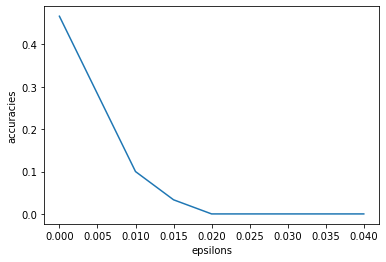

In [11]:
net.load_state_dict(torch.load(PATH))
net.eval()

# 扰动
epsilons = [0, .01, .015, .02, .025, .03, .035, .04]
accuracies = []


class PGD(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model # 必须是pytorch的model
        self.device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

    def generate(self, x, **params):
        self.parse_params(**params)
        labels = self.y
        adv_x = self.attack(x, labels)
        return adv_x

    def parse_params(self, eps=0.3, iter_eps=0.001, nb_iter=100, clip_min=0.0, clip_max=1.0, C=0.0,
                     y=None, ord=np.inf, rand_init=True, flag_target=False):
        self.eps = eps
        self.iter_eps = iter_eps
        self.nb_iter = nb_iter
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.y = y
        self.ord = ord
        self.rand_init = rand_init
        self.model.to(self.device)
        self.flag_target = flag_target
        self.C = C

    def sigle_step_attack(self, x, pertubation, labels):
        adv_x = x + pertubation
        # get the gradient of x
        # get the gradient of x
        adv_x = Variable(adv_x)
        adv_x.requires_grad = True
        loss_func = nn.CrossEntropyLoss()
        preds = self.model(adv_x)
        if self.flag_target:
            loss = -loss_func(preds, labels)
        else:
            loss = loss_func(preds, labels)
            # label_mask=torch_one_hot(labels)
            #
            # correct_logit=torch.mean(torch.sum(label_mask * preds,dim=1))
            # wrong_logit = torch.mean(torch.max((1 - label_mask) * preds, dim=1)[0])
            # loss=-F.relu(correct_logit-wrong_logit+self.C)
        self.model.zero_grad()
        loss.backward()
        grad = adv_x.grad.data
        # get the pertubation of an iter_eps
        pertubation = self.iter_eps * np.sign(grad)
        adv_x = adv_x.cpu().detach().numpy() + pertubation.cpu().numpy()
        x = x.cpu().detach().numpy()
        pertubation = np.clip(adv_x, self.clip_min, self.clip_max) - x
        pertubation = np.clip(pertubation, -self.eps, self.eps)
        return pertubation

    def attack(self, x, labels):
        labels = labels.to(self.device)
        #print(self.rand_init)
        if self.rand_init:
            x_tmp = x + torch.Tensor(np.random.uniform(-self.eps, self.eps, x.shape)).type_as(x)
        else:
            x_tmp = x
        pertubation = torch.zeros(x.shape).type_as(x).to(self.device)
        for i in range(self.nb_iter):
            pertubation = self.sigle_step_attack(x_tmp, pertubation=pertubation, labels=labels)
            pertubation = torch.Tensor(pertubation).type_as(x).to(self.device)
        adv_x = x + pertubation
        adv_x = np.clip(adv_x, self.clip_min, self.clip_max)
        return adv_x

pgd = PGD(net)

def test(model, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    examples = []
    diffs = []

    # 迭代梯度
    for data, labels in test_loader:

        inputs, labels = data, labels

        output = net(inputs)  # 带入图片

        init_pred = output.max(1, keepdim=True)[1]  # 开始预测

        if init_pred.item() != labels.item():  # 如果预测错误的话则是本来就分类错的样本
            continue  # 如果预测正确就是要进行扰动的样本

        pgd.parse_params(eps=epsilon)

        perturbed_inputs = pgd.attack(inputs, labels)  # 制作扰动图像

        output = net(perturbed_inputs)  # 带入识别扰动图像

        final_pred = output.max(1, keepdim=True)[1]  # 看扰动后图像的标签

        if final_pred.item() == labels.item():  # 如果添加扰动后依然识别成功
            correct += 1

        # 原本的图片
        ori = inputs[0]
        ori = torch.as_tensor(ori)  # 转为tensor
        ori = ori.detach().numpy()  # 去除梯度
        ori = np.transpose(ori, (1, 2, 0))  # 转置

        # 加了扰动后的图片
        img = perturbed_inputs[0]  # plt.imshow()只能接受3-d tensor，所以也要用image[0]消去batch那一维
        img = torch.as_tensor(img)
        img = img.detach().numpy()  # floattensor转为ndarray
        img = np.transpose(img, (1, 2, 0))  # 把channel那一维放到最后

        diff = 255 * (ori - img)

        examples.append(img)
        diffs.append(diff)

    #plt.figure(figsize=(30, 30))

    #plt.imshow(examples[1])
    #plt.show()
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, correct, len(test_loader), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc

# Run test for each epsilon
for eps in epsilons:
    acc = test(net, attackloader, eps)
    accuracies.append(acc)

plt.plot(epsilons, accuracies)
plt.xlabel("epsilons")
plt.ylabel("accuracies")
plt.show()



In [24]:
file.close()